In [119]:
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import seaborn as sns
from scipy import stats
from theano import tensor as tt
import pandas as pd
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
SEED = 5132290 # from random.org
np.random.seed(SEED)

https://www.ritchievink.com/blog/2018/06/05/clustering-data-with-dirichlet-mixtures-in-edward-and-pymc3/

https://docs.pymc.io/notebooks/dp_mix.html

https://www.datasciencecentral.com/profiles/blogs/6448529:BlogPost:635167

https://stackoverflow.com/questions/41553988/how-to-extract-unsupervised-clusters-from-a-dirichlet-process-in-pymc3

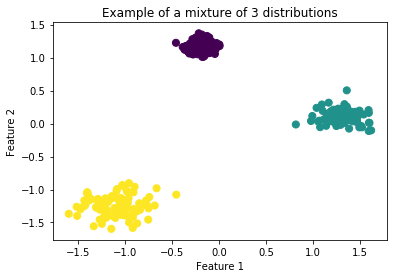

In [124]:
n_components = 3
X, truth = make_blobs(n_samples=300, centers=n_components, 
                      cluster_std = [0.5, 0.7, 1], 
                      random_state=42)

X = StandardScaler().fit_transform(X)

plt.scatter(X[:, 0], X[:, 1], s=50, c = truth)
plt.title(f"Example of a mixture of {n_components} distributions")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2");

In [125]:
inputData= X[:,:, np.newaxis]

In [ ]:
def stick_breaking(v):
    return v * tt.concatenate([tt.ones_like(v[..., :1]),
                               tt.extra_ops.cumprod(1 - v, axis=1)[..., :-1]],
                              axis=1)

K = 10
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=(1, K))
    w = pm.Deterministic('w', stick_breaking(beta))
    w = w/w.sum()

    tau = pm.Gamma('tau', 1., 1., shape=(2, K))
    lambda_ = pm.Uniform('lambda', 0,3, shape=(2, K))
    mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=(2, K))
    obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau, comp_shape=(2, K),
                           observed=inputData)
    trace = pm.sample(1000, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 2 chains:   6%|███▎                                                    | 179/3000 [00:45<10:33,  4.45draws/s]

In [128]:
trace['w'].mean(0).ravel()

array([3.34595569e-01, 1.67880296e-01, 3.31056613e-01, 1.65443377e-01,
       5.76813879e-04, 2.47498602e-04, 1.08140612e-04, 4.58160009e-05,
       2.43305454e-05, 9.52303637e-06])

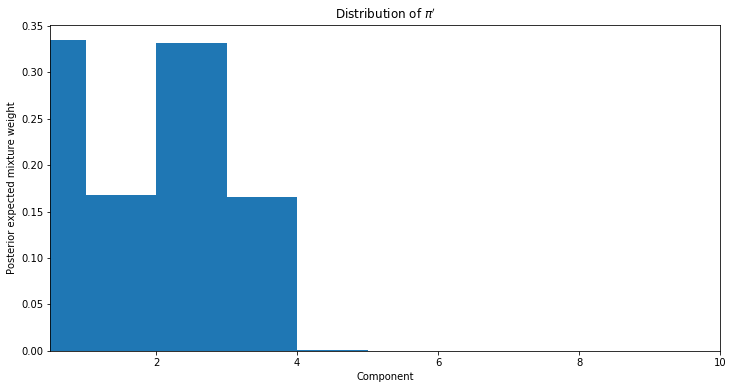

In [129]:
plt.figure(figsize=(12, 6))
plt.title(r"Distribution of $\pi'$")
plt.bar(np.arange(K) + 1 - 0.5, trace['w'].mean(axis=0).ravel(), width=1., lw=0);
plt.xlim(0.5, K);
plt.xlabel('Component');
plt.ylabel('Posterior expected mixture weight');

In [131]:
idx = 0
mu_mean[idx], psd[0][idx], pi_mean[idx]

(array([-1.07055753,  1.05996488, -4.68096817,  0.01037817,  0.4529134 ,
         0.23876046,  0.19012737,  0.12520383,  0.03825273,  0.08066762]),
 array([0.62716064, 0.4737729 , 0.48460131, 0.69893589, 0.69320723,
        0.69357309, 0.68972013, 0.6941989 , 0.6896917 , 0.69764899]),
 0.3341701839882295)

In [132]:
x = np.linspace(-3,  3, 100)
pi_mean = trace['w'].mean(0).ravel()
mu_mean = trace['mu'].mean(0) 
lambda_mean = trace['lambda'].mean(0)
tau_mean = trace['tau'].mean(0)
sd_mean = np.sqrt((1 / tau_mean * lambda_mean))
tau_sd = trace['mu'].std(0)
lambda_sd = trace['lambda'].std(0)
sd_std = np.sqrt((1 / tau_sd * lambda_sd))

p = stats.norm.interval(0.05, trace['mu'].mean(0), trace['mu'].std(0))
psd = stats.norm.interval(0.05, sd_mean, sd_std)

In [133]:
X[0], sd_mean.shape, sd_std.shape, pi_mean.shape, mu_mean.shape

(array([-1.18813797, -1.37646971]), (2, 10), (2, 10), (10,), (2, 10))

In [140]:
nClusters = 4
res = np.zeros((len(X), nClusters))
res.shape

for i in range(len(X)):
    for idx in range(nClusters):
        res[i, idx] =stats.multivariate_normal.pdf(X[i], 
                            mean=mu_mean[:, idx], cov=np.diag(sd_mean[:, idx])) * pi_mean[idx]#

clusters = res.argmax(axis =1)

In [141]:
mu_mean[:, 0]

array([ 0.54088883, -0.5767316 ])

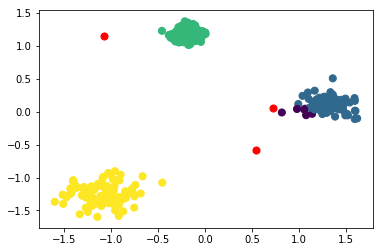

In [142]:
plt.scatter(X[:, 0], X[:, 1], s=50, c = clusters)
for idx in range(3):
    plt.scatter(mu_mean[:, idx][0], mu_mean[:, idx][1], s=50, c = 'red')
    